In [1]:
# MSS used from screen capture
from mss import mss
# Sending commands to game.
import pydirectinput

# Googles OCR package used to know when the game ends.
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# OpenCV allows us to do frame processing
import cv2

import numpy as np
from matplotlib import pyplot as plt
import time

# Environment components
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.crop_width, self.crop_height = 80, 60
        self.observation_space = Box(low=0, high=255, shape=(1,self.crop_height,self.crop_width), dtype=np.uint8)
        self.action_space = Discrete(3)

        with mss() as sct:
            self.mon0 = sct.monitors[0]
            self.mon1 = sct.monitors[1]
            self.mon2 = sct.monitors[2]
            print("Net Display:", self.mon0)
            print("Display 1:  ", self.mon1)
            print("Display 2:  ", self.mon2)

        # Extraction parameters for the game.
        self.cap = mss()
        self.game_location = {'top':self.mon2['top'] + 130, 'left':self.mon2['left'] + 100, 'width':400, 'height':300}
        self.done_location = {'top':self.mon2['top'] + 210, 'left':self.mon2['left'] + 480, 'width':190, 'height':45}

    def step(self, action):
        # 0 = Jump, 1 = Duck, 2 = No Action
        action_map = {0: 'space', 1: 'down', 2: 'no_op'}
        if action != 2:
            pydirectinput.press(action_map[action])
        done, _ = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        return new_observation, reward, done, info

    def reset(self):
        time.sleep(0.01)
        pydirectinput.click(x=self.mon2['top'] + 200, y=self.mon2['left'] + 200)
        pydirectinput.press('space')
        return self.get_observation()

    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) and 0xFF == ord('q'):
            self.close()

    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):        
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (self.crop_width, self.crop_height))
        channel = np.reshape(resized, (1, self.crop_height, self.crop_width))
        return channel

        
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done_strings = ["GAME", "GAHE"]
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [3]:
env = WebGame()

Net Display: {'left': 0, 'top': 0, 'width': 3926, 'height': 1440}
Display 1:   {'left': 0, 'top': 0, 'width': 2560, 'height': 1440}
Display 2:   {'left': 2560, 'top': 339, 'width': 1366, 'height': 768}


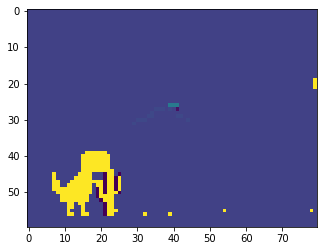

In [4]:
obs = env.get_observation()
# plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))
plt.imshow(env.get_observation()[0])

True


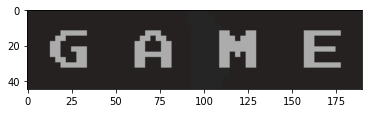

In [5]:
status = env.get_done()
print(status[0])
plt.imshow(status[-1])

In [6]:
import os 

from stable_baselines3.common.callbacks import BaseCallback

from stable_baselines3 import DQN

In [7]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [8]:
CHECKPOINT_DIR = './Saved_Models'
LOG_DIR = './Logs/'

In [9]:
callback = TrainAndLoggingCallback(check_freq=500, save_path=CHECKPOINT_DIR)

In [10]:
env = WebGame()
model = None

Net Display: {'left': 0, 'top': 0, 'width': 3926, 'height': 1440}
Display 1:   {'left': 0, 'top': 0, 'width': 2560, 'height': 1440}
Display 2:   {'left': 2560, 'top': 339, 'width': 1366, 'height': 768}


In [13]:
def LatestModelLoad():
    global model
    path = "C:\\AnCodeRR\\Google_Dino_Game_AI\\Saved_Models\\"
    saves = os.listdir(path=path)
    if len(saves) == 0: 
        return
    len_to_shave = len("best_model_")
    best_version = max([int(s[len_to_shave:-4]) for s in saves])
    model = DQN.load(f"C:\\AnCodeRR\\Google_Dino_Game_AI\\Saved_Models\\best_model_{best_version}.zip", env=env, )

In [16]:
LatestModelLoad()
if not model:
    model = DQN(
        policy = 'CnnPolicy', 
        env = env, 
        tensorboard_log = LOG_DIR, 
        verbose = 1, 
        buffer_size = 100000, 
        learning_starts = 0)
# model.save('./base.zip')

In [17]:
model.learn(total_timesteps=1000, callback=callback)

Logging to ./Logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.75     |
|    ep_rew_mean      | 4.75     |
|    exploration_rate | 0.819    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 13       |
|    total_timesteps  | 19       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.465    |
|    n_updates        | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.25     |
|    ep_rew_mean      | 6.25     |
|    exploration_rate | 0.525    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 26       |
|    total_timesteps  | 50       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375  

KeyboardInterrupt: 

In [51]:
def automated_player(episodes, use_dqn=False):
    i = 0
    for episode in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            i += 1 
            if use_dqn:
                action, _ = model.predict(obs)
                obs, reward, done, _ = env.step(int(action))
            else:
                obs, reward , done, _ = env.step(env.action_space.sample())
            plt.imsave(fname=f"C:\AnCodeRR\Google_Dino_Game_AI\{i}.png", arr=obs[0])
            total_reward += reward
        print(f'Total Reward for epoch {episode} is {total_reward}')

In [35]:
# automated_player(10, False)

KeyboardInterrupt: 

In [ ]:
#   automated_player(10, True)